# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/generative_deep_learning

/content/drive/MyDrive/generative_deep_learning


In [3]:
cd GDL_code

/content/drive/MyDrive/generative_deep_learning/GDL_code


# Import

In [17]:
import os
from utils.loaders import load_mnist

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [5]:
DEVICE= 'cuda:0' if torch.cuda.is_available() else 'cpu'
# LEARNING_RATE = 0.0005
# BATCH_SIZE = 32
# EPOCHS = 200
print(DEVICE)

cuda:0


In [6]:
(x_train, y_train), (x_test, y_test) = load_mnist()

11493376/11490434 [==============================] - 0s 0us/step


# Dataset

In [7]:
def keras_to_torch_tensor(array):
    array = array.transpose(0, 3, 1, 2) # keras: N x H x W x C -> torch: N x C x H x W
    array = torch.tensor(array, dtype=torch.float32).to(DEVICE)
    return array

def y_to_torch_tensor(array):
    return torch.tensor(array, dtype=torch.float32).unsqueeze(-1).to(DEVICE)

x_train = keras_to_torch_tensor(x_train)
y_train = y_to_torch_tensor(y_train)

x_test = keras_to_torch_tensor(x_test)
y_test = y_to_torch_tensor(y_test)

print(x_train.shape)

torch.Size([60000, 1, 28, 28])


In [8]:
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

# Model

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.l_relu1 = torch.nn.LeakyReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.l_relu2 = torch.nn.LeakyReLU()
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.l_relu3 = torch.nn.LeakyReLU()
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.l_relu4 = torch.nn.LeakyReLU()
        self.ln = nn.Linear(3136, 2)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.l_relu1(x)
        x = self.conv2(x)
        x = self.l_relu2(x)
        x = self.conv3(x)
        x = self.l_relu3(x)
        x = self.conv4(x)
        x = self.l_relu4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.ln(x)
        return x

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.ln = nn.Linear(2, 3136)
        self.conv1 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.l_relu1 = torch.nn.LeakyReLU()
        self.conv2 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)
        self.l_relu2 = torch.nn.LeakyReLU()
        self.conv3 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)
        self.l_relu3 = torch.nn.LeakyReLU()
        self.conv4 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.ln(x)
        x = x.reshape(-1, 64, 7, 7)
        x = self.conv1(x)
        x = self.l_relu1(x)
        x = self.conv2(x)
        x = self.l_relu2(x)
        x = self.conv3(x)
        x = self.l_relu3(x)
        x = self.conv4(x)
        x - self.sigmoid(x)
        return x

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [43]:
model = AutoEncoder()
model.load_state_dict(torch.load('../output/model_03_01.pth'))
model.to(DEVICE)
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (l_relu1): LeakyReLU(negative_slope=0.01)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (l_relu2): LeakyReLU(negative_slope=0.01)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (l_relu3): LeakyReLU(negative_slope=0.01)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (l_relu4): LeakyReLU(negative_slope=0.01)
    (ln): Linear(in_features=3136, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (ln): Linear(in_features=2, out_features=3136, bias=True)
    (conv1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (l_relu1): LeakyReLU(negative_slope=0.01)
    (conv2): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (l_relu2): LeakyReLU(negative_slope=0.01)
    (conv3): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=

# Reconstructing Original Paintings

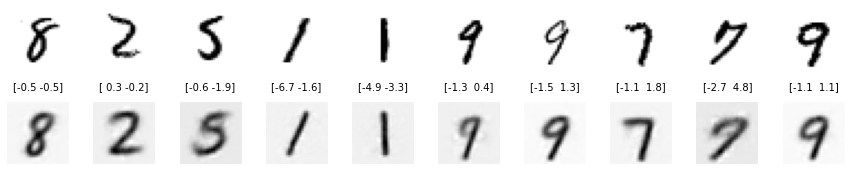

In [40]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = model.encoder(example_images)

reconst_images = model.decoder(z_points)

z_points = z_points.detach().cpu().numpy()
reconst_images = reconst_images.detach().cpu().numpy()
example_images = example_images.detach().cpu().numpy()

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

  

# Mr N. Coder's wall

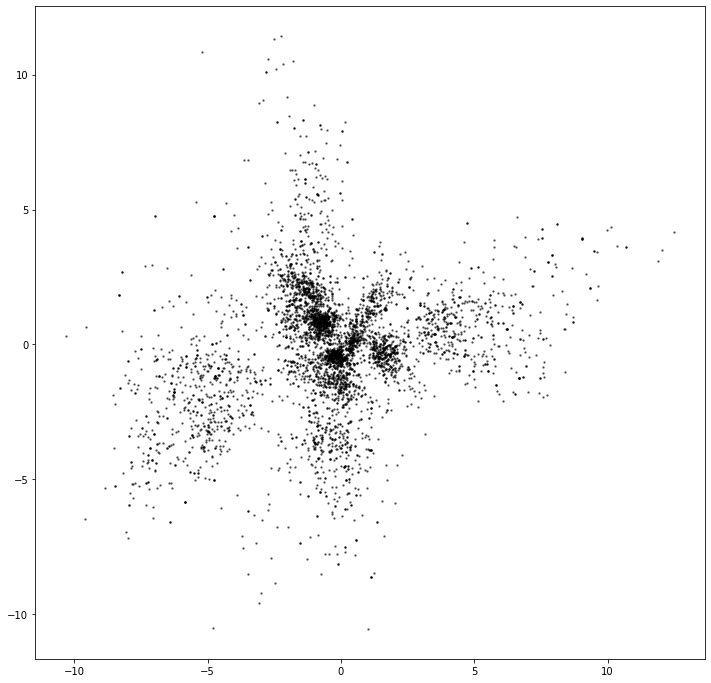

In [46]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = model.encoder(example_images)
z_points = z_points.detach().cpu().numpy()

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

# The new generated art exhibition

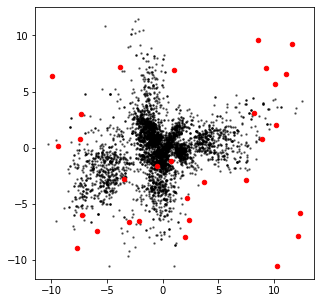

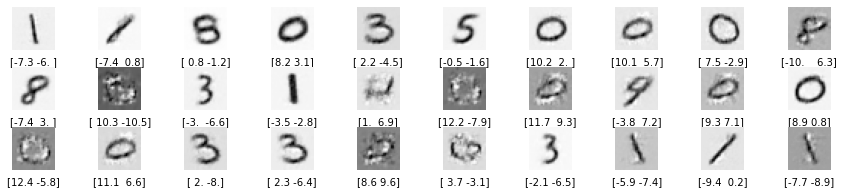

In [58]:
figsize = 5

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
z_grid = torch.tensor(z_grid, dtype=torch.float32).to(DEVICE)

reconst = model.decoder(z_grid)
z_grid = z_grid.detach().cpu().numpy()
reconst = reconst.detach().cpu().numpy()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    img = reconst[i].squeeze()
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(img, cmap = 'Greys')

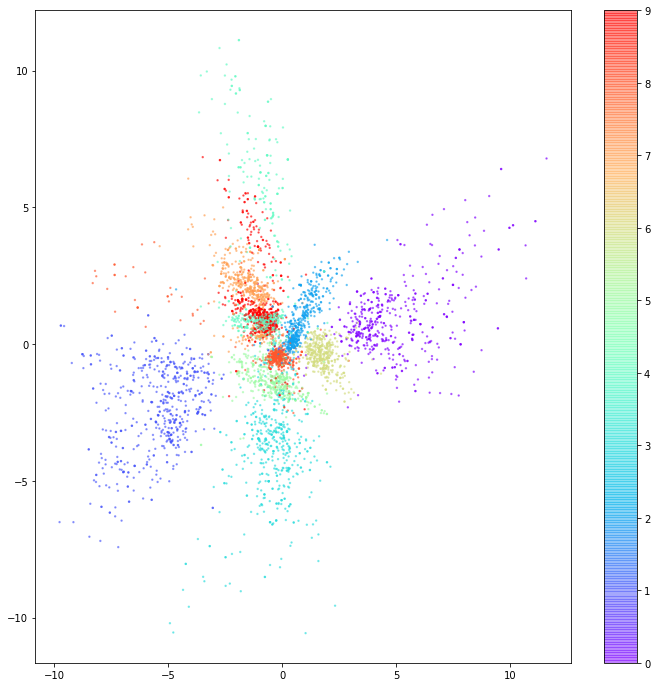

In [60]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = model.encoder(example_images)
z_points = z_points.detach().cpu().numpy()
example_labels = example_labels.detach().cpu().numpy()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

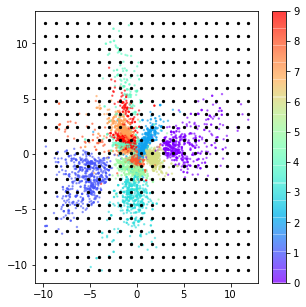

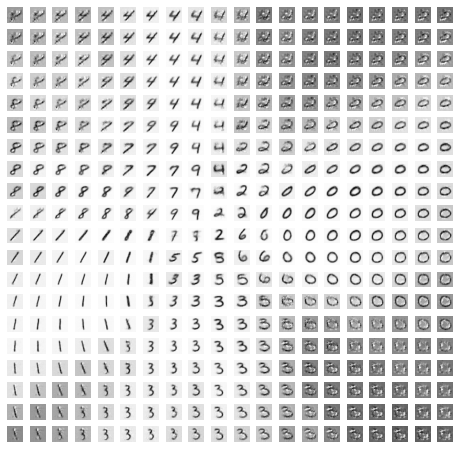

In [62]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = model.encoder(example_images)
z_points = z_points.detach().cpu().numpy()
example_labels = example_labels.detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))
z_grid = torch.tensor(z_grid, dtype=torch.float32).to(DEVICE)

reconst = model.decoder(z_grid)
z_grid = z_grid.detach().cpu().numpy()
reconst = reconst.detach().cpu().numpy()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    img = reconst[i].squeeze()
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(img, cmap = 'Greys')